# IPL Win Predictor

## 1. Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle

## 2. Load datasets

In [2]:
match = pd.read_csv('matches.csv')
delivery = pd.read_csv('deliveries.csv')

In [3]:
match.head(5)

,id,Season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,IPL-2017,Hyderabad,05-04-2017,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,IPL-2017,Pune,06-04-2017,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN
2,3,IPL-2017,Rajkot,07-04-2017,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN
3,4,IPL-2017,Indore,08-04-2017,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN
4,5,IPL-2017,Bangalore,08-04-2017,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN


In [4]:
delivery.head(5)

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,4,0,4,NaN,NaN,NaN
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,2,2,NaN,NaN,NaN


## 3. Preprocess match data

In [5]:
total_score_df = delivery.groupby(['match_id','inning'])['total_runs'].sum().reset_index()
total_score_df = total_score_df[total_score_df['inning'] == 1]

In [6]:
match_df = match.merge(total_score_df[['match_id','total_runs']], left_on='id', right_on='match_id')
teams = [
    'Sunrisers Hyderabad','Mumbai Indians','Royal Challengers Bangalore',
    'Kolkata Knight Riders','Kings XI Punjab','Chennai Super Kings',
    'Rajasthan Royals','Delhi Capitals'
]

In [7]:
# Standardizing team names
match_df['team1'] = match_df['team1'].replace({'Delhi Daredevils':'Delhi Capitals', 'Deccan Chargers':'Sunrisers Hyderabad'})
match_df['team2'] = match_df['team2'].replace({'Delhi Daredevils':'Delhi Capitals', 'Deccan Chargers':'Sunrisers Hyderabad'})

In [8]:
match_df = match_df[match_df['team1'].isin(teams) & match_df['team2'].isin(teams)]
match_df = match_df[match_df['dl_applied'] == 0]
match_df = match_df[['match_id', 'city', 'winner', 'total_runs']]

## 4. Merge with delivery data

In [9]:
delivery_df = match_df.merge(delivery, on='match_id')
delivery_df = delivery_df[delivery_df['inning'] == 2].copy()

## 5. Feature Engineering

In [10]:
delivery_df['current_score'] = delivery_df.groupby('match_id')['total_runs_y'].cumsum()

In [11]:
# Runs Left
delivery_df['runs_left'] = delivery_df['total_runs_x'] - delivery_df['current_score']

In [12]:
# Balls Left
delivery_df['balls_left'] = 120 - (delivery_df['over'] * 6 + delivery_df['ball'])

In [13]:
# Wickets
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].fillna(0)
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].apply(lambda x: 0 if x == 0 else 1)
delivery_df['wickets_fallen'] = delivery_df.groupby('match_id')['player_dismissed'].cumsum()
delivery_df['wickets'] = 10 - delivery_df['wickets_fallen']

## 6. More Features

In [14]:
delivery_df['crr'] = (delivery_df['current_score'] * 6) / (120 - delivery_df['balls_left'] + 1)
delivery_df['rrr'] = (delivery_df['runs_left'] * 6) / delivery_df['balls_left']
delivery_df['result'] = delivery_df.apply(lambda row: 1 if row['batting_team'] == row['winner'] else 0, axis=1)

## 7. Final Dataset

In [15]:
final_df = delivery_df[['batting_team','bowling_team','city','runs_left','balls_left','wickets',
                        'total_runs_x','crr','rrr','result']].dropna()
final_df = final_df[final_df['balls_left'] != 0]

## 8. Train/Test Split

In [16]:
X = final_df.iloc[:, :-1]
y = final_df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## 9. Pipeline: OneHotEncoding + LogisticRegression

In [17]:
trf = ColumnTransformer([
    ('trf', OneHotEncoder(sparse_output=False, drop='first'), ['batting_team', 'bowling_team', 'city'])
], remainder='passthrough')

pipe = Pipeline(steps=[
    ('step1', trf),
    ('step2', LogisticRegression(solver='liblinear'))
])
pipe.fit(X_train, y_train)


C:\Users\Omkar A. Patil\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('step1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('trf',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['batting_team',
                                                   'bowling_team', 'city'])])),
                ('step2', LogisticRegression(solver='liblinear'))])

## 10. Accuracy

In [18]:
y_pred = pipe.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7978925184404636


## 11. Save Model

In [19]:
pickle.dump(pipe, open('pipe.pkl', 'wb'))

## 12. Match Progression Plot Function

In [20]:
def match_progression(x_df, match_id, pipe):
    match = x_df[x_df['match_id'] == match_id].copy()
    match = match[(match['ball'] == 6)]
    temp_df = match[['batting_team','bowling_team','city','runs_left','balls_left','wickets','total_runs_x','crr','rrr']].dropna()
    temp_df = temp_df[temp_df['balls_left'] != 0]

    result = pipe.predict_proba(temp_df)
    temp_df['lose'] = np.round(result.T[0]*100, 1)
    temp_df['win'] = np.round(result.T[1]*100, 1)
    temp_df['end_of_over'] = range(1, temp_df.shape[0]+1)

    target = temp_df['total_runs_x'].values[0]
    runs = list(temp_df['runs_left'].values)
    new_runs = runs[:]
    runs.insert(0, target)
    temp_df['runs_after_over'] = np.array(runs)[:-1] - np.array(new_runs)

    wickets = list(temp_df['wickets'].values)
    new_wickets = wickets[:]
    new_wickets.insert(0, 10)
    wickets.append(0)
    temp_df['wickets_in_over'] = (np.array(new_wickets) - np.array(wickets))[:temp_df.shape[0]]

    print("Target:", target)
    return temp_df[['end_of_over', 'runs_after_over', 'wickets_in_over', 'lose', 'win']], target


## 13. Plotting Match Progression

Target: 178


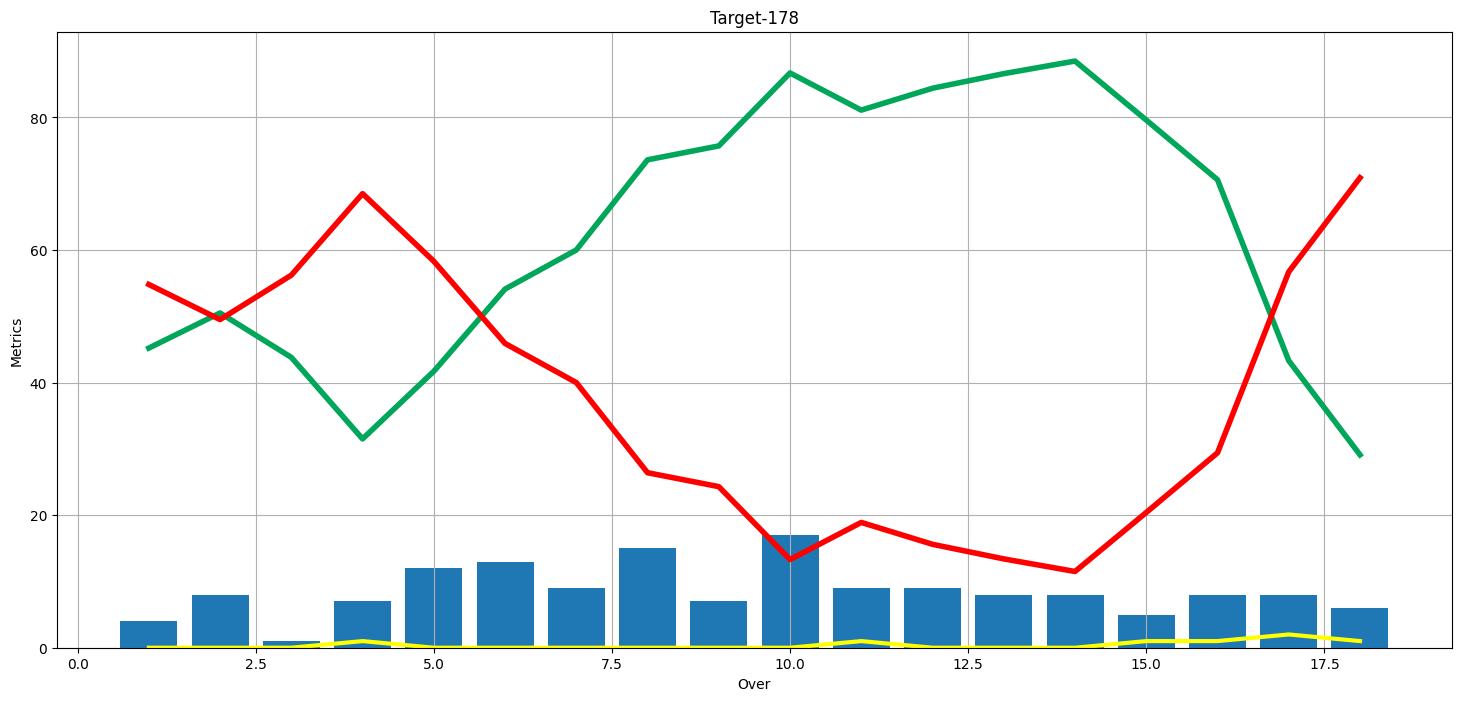

In [21]:
temp_df, target = match_progression(delivery_df, 74, pipe)
plt.figure(figsize=(18,8))
plt.plot(temp_df['end_of_over'], temp_df['wickets_in_over'], color='yellow', linewidth=3)
plt.plot(temp_df['end_of_over'], temp_df['win'], color='#00a65a', linewidth=4)
plt.plot(temp_df['end_of_over'], temp_df['lose'], color='red', linewidth=4)
plt.bar(temp_df['end_of_over'], temp_df['runs_after_over'])
plt.title('Target-' + str(target))
plt.xlabel('Over')
plt.ylabel('Metrics')
plt.grid(True)
plt.show()
